## Analyzing Financial Time Series with Persistent Homology

#### Othmane AitBoumlik  and Khalil Bergaoui

(othmane.aitboumlik@student.ecp.fr ; khalil.bergaoui@student.ecp.fr)

#### Course Project FGMDA : March 17th 2021

The project is based on the following paper
https://arxiv.org/pdf/1703.04385.pdf

In this project, we will reproduce the results presented in the paper entitled "Topological data analysis of financial time series : Landscapes of crashes" in which the authors use the norms of persistence landscapes as indicators to help detect early warning signals of imminent market crashes.

This notebook is divided into 4 main sections:

### 1. Data preprocessing


### 2. Persistence diagram - Persistence Landscapes

  #### 2.1 Persistence diagram - gudhi library
    
  #### 2.2 Persistence Landscapes implementation

### 3. Reproducing the results of section 4 of the paper

   #### 3.1 Method implementation and impact of the window size 
    
   #### 3.2 Computing relevant statistics : variance, average spectral density , ACF
    
    
### 4. Experiments with the difference between consecutive landscapes



## 1 Data preproceesing

The data that is used corresponds to the daily time series of four major US stock market indices:  S&P 500,DJIA, NASDAQ, and Russel 2000 between December 23, 1987 and December 08, 2016(7301 trading days).

(dataset can be found here http://www-sop.inria.fr/abs/teaching/centrale-FGMDA/exam_mathieu/TDA_projects.html)


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Dec 17 15:09:34 2017

@author: Frederic Chazal - All rigths reserved
"""

import numpy as np
import pandas as pd
import pickle 

import csv
import time as tm
import seaborn as sns

In [3]:
#Getting the data
#Setting the path to the data
data_path = "./data/"

DowJones_pd = pd.read_csv(data_path + "DowJones.csv",header=0,delimiter=",")
Nasdaq_pd = pd.read_csv(data_path + "Nasdaq.csv",header=0,delimiter=",")
Russell2000_pd = pd.read_csv(data_path + "Russell2000.csv",header=0,delimiter=",")
SP500_pd = pd.read_csv(data_path + "SP500.csv",header=0,delimiter=",")

DowJones_pd.head(5)

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-12-08,19559.939453,19664.970703,19527.830078,19614.810547,324570000,19614.810547
1,2016-12-07,19241.990234,19558.419922,19229.830078,19549.619141,385200000,19549.619141
2,2016-12-06,19219.910156,19255.890625,19184.740234,19251.779297,284960000,19251.779297
3,2016-12-05,19244.349609,19274.849609,19186.730469,19216.240234,317800000,19216.240234
4,2016-12-02,19161.250000,19196.140625,19141.179688,19170.419922,84920000,19170.419922


In [5]:
#Close is the daily return
DJ = DowJones_pd.Close.to_numpy()
Nasdaq = Nasdaq_pd.Close.to_numpy()
Rus = Russell2000_pd.Close.to_numpy()
SP500 = SP500_pd.Close.to_numpy()

#convert to numpy ND array
DJ = DJ.reshape(len(DJ),1)
Nasdaq = Nasdaq.reshape(len(Nasdaq),1)
Rus = Rus.reshape(len(Rus),1)
SP500 = SP500.reshape(len(SP500),1)

# above 4 arrays have shape (7301,4)
# element 7301 corresponds to day 1987-12-23 and first element corresponds to day 2016-12-08
# every row represents a single day

ts = np.concatenate((DJ.transpose(),Nasdaq.transpose(),Rus.transpose(),SP500.transpose()))

As in section 4 of the paper we compute the log returns $log(\frac{P^i_{n}}{P^i_{n-1}})$ where $P^i_{n}$ is the closing return of stock $i (1\leq i\leq 4$) at trading day $n$

In [6]:
log_returns = np.diff(-np.log(ts),axis=1) #log(P(i,j)/P(i,j-1))
#computing the log returns eliminates the date '1987-12-23' corresponding to last row because this date
#does not have previous value

Then we extract ordered time series sliding window by specifying the end data and the winodw size.

In [7]:
def get_date_index(date,df):
    """
    Returns the index of the row corresponding the the input @date in the dataframe @df
    
    @date: string of the form 'yyyy-mm--dd'
    @df : pandas dataframe
    """
    
    index_list =df.index[df['Date']==date].tolist()
    try:
        out= index_list[0]
    except:
        print('Day {} is missing from data! Please enter a valid date.'.format(date))
        out = None
        
    return out
              
  

def get_sliding_window_from_date_index(data_array,date_index,window_size):
    """
    Returns time ordered sliding window of size @window_size starting from input @date
    
    @data_array: input array of multivariate time series of shape (d,n) where d is the number of 1D time series
    @date:string of the form 'yyyy-mm--dd'
    @window_size: integer value of the size of the wanted window
    """

    
    #day @date corresponds to @data_array[date_index]
    #next rows correspond to previous days
    sliding_window = data_array[:,date_index:date_index + window_size]
    
    #flip to have increasing order i.e next days will come after in the flipped array
    time_ordered_sliding_window = np.flip(sliding_window,1)
    return time_ordered_sliding_window
    
def get_sliding_window_from_date(data_array,date,window_size,df=DowJones_pd):
    """
    Returns time ordered sliding window of size @window_size starting from input @date
    
    @data_array: input array of multivariate time series of shape (d,n) where d is the number of 1D time series
    @date:string of the form 'yyyy-mm--dd'
    @window_size: integer value of the size of the wanted window
    """

    date_index = get_date_index(date,df)
    time_ordered_sliding_window = get_sliding_window_from_date_index(data_array,date_index,window_size)
    
    return time_ordered_sliding_window
    
    

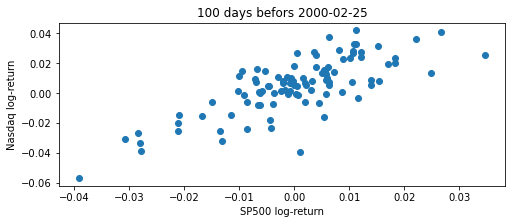

In [8]:
ending_date = '2000-02-25'
window_size = 100
window = get_sliding_window_from_date(log_returns,ending_date,window_size,df=DowJones_pd)
assert window.shape[1] == window_size
import matplotlib.pyplot as plt
#plot needs to be normalized to match Figure 7 of the paper

sp500_w = window[3]
nasdaq_w = window[1]
plt.figure(figsize=(8,3))
plt.scatter(sp500_w,nasdaq_w)
plt.xlabel('SP500 log-return')
plt.ylabel('Nasdaq log-return')
tt =plt.title('{} days befors {}'.format(window_size,ending_date))

- As a sanity check for our dataprocessing, we plot the above figure as in Figure 7 of the paper.

Now that our data is correctly processed, we can move to computing persistence diagrams and analyzing persistence landscapes.

## 2. Persistence diagram - Persistence Landscapes

### 2.1 Persistence diagram - gudhi library

Here, we choose a day $d$ and pick $w$ days that come right before this date to form a point cloud. From the set of $w$ datapoints in $\mathbb{R}^{4}$, we compute persistence diagram using the Rip-Vitoris filtration.

In [9]:
import gudhi as gd
import gudhi.representations
from gudhi import plot_persistence_diagram

In [10]:
#Fix parameters to reproduce Figure 8 from paper

ending_date = '2008-09-15'#'2000-03-10'
window_size = 50
window = get_sliding_window_from_date(log_returns,ending_date,window_size,df=DowJones_pd)

In [11]:
skeleton = gd.RipsComplex(points = window.T, max_edge_length = 0.05)
Rips_simplex_tree_sample = skeleton.create_simplex_tree(max_dimension = 2)
dgm = Rips_simplex_tree_sample.persistence()

In [32]:
#We can display some elements of the persistence diagram
for i in range(25):
    print(dgm[i])

(1, (0.01174692136803735, 0.015351498872754808))
(1, (0.016719200011755603, 0.02014989682275647))
(1, (0.010629295114415975, 0.011802707901758093))
(1, (0.012948198648351183, 0.01375008663417751))
(1, (0.005951898017778947, 0.006647768837374706))
(1, (0.007939437192028186, 0.008447284027362157))
(1, (0.0127319401705889, 0.012909056705414756))
(1, (0.01308677870958075, 0.013150327071677724))
(0, (0.0, inf))
(0, (0.0, 0.026207998790701025))
(0, (0.0, 0.015854203508576997))
(0, (0.0, 0.015616703187384054))
(0, (0.0, 0.013907033372525291))
(0, (0.0, 0.012311381012822266))
(0, (0.0, 0.011649529726708279))
(0, (0.0, 0.011007210468349782))
(0, (0.0, 0.010935097515138714))
(0, (0.0, 0.010867894892211924))
(0, (0.0, 0.01021127064035606))
(0, (0.0, 0.01014530289968075))
(0, (0.0, 0.010094637838877688))
(0, (0.0, 0.010019377207787492))
(0, (0.0, 0.009896278689221567))
(0, (0.0, 0.009893751986070433))
(0, (0.0, 0.009766533856146146))


usetex mode requires TeX.


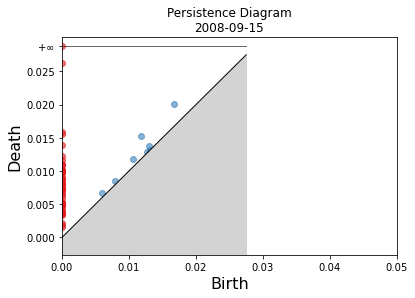

In [13]:
gd.plot_persistence_diagram(dgm)
plt.xlim(0,0.05)
tt = plt.title('Persistence Diagram\n{}'.format(ending_date))



- The obtained diagram is comparable to the persistence diagram appearing in Figure 8 of the paper for the same date. 1-dimensional features are displayed in blue dots in the above figure, and in the paper they are displayed using red triangles.


- We will now compute the persistence landscapes as described in the paper.

### 2.2 Persistance landscape as in Equations (2.1) and (2.2) in section 2 of the paper.

In [1]:
def f_pw(diagram_point_coordinates,x):
    """
    Piecewise linear function defined for each birdth-date point of the persistence diagram
    The implementation corresponds to equation (2.1) in the paper
    @diagram_point_coordinates : birth-death point of a persistence diagram
    @x: float value corresponding to the point in which we would like to evaluate the function f_pw(x)
    """
    
    lower , upper = diagram_point_coordinates
    mid = (lower+upper)/ 2
    
    if x<=lower:
        return 0
    
    else:
        if x<upper:
            if x<= mid:
                return x-lower
            else:
                return upper - x
            
        else:
            return 0
    

def get_persistence_landscapes(dgm,k,x_min,x_max,nb_nodes,nb_ld):
    
    """
    Returns an array of shape (nb_ld,nb_nodes) where the ith row corresponds to the ith landscape
    We use the definition of the ith landscape as equation (2.2) of the paper
    
    @dgm: persistence diagram in the form of a list of tuples where each tuple has the format (d,(x,y)) where
    d is the dimension of the topological feature and (x,y) is the birth-death point
    
    @x_min and @x_max: float values corresponding to bounds of the interval [x_min,x_max] in which we want to evaluate the landscapes
    
    @nb_nodes: integer value of the number of points we want to sample the interval [x_min,x_max]
    @nb_ld: integer >= 1 corresponding to the number of landscapes we want to compute
    """
    #initialize empty set of 
    dim_features = []
    
    #initialize landscapes to zero
    landscapes = np.zeros((nb_ld, nb_nodes))
    
    #loop over sampled points over the interval [x_min,x_max]
    for i,x in enumerate(np.linspace(x_min,x_max,nb_nodes)):
        x_evals = []
        #For every point compute the sequence of landscape values
        
        for tup in dgm:
            
            if tup[0] == k:
                #k dimensional features of the persistence diagram
                dgm_ftr_point = tup[1]
                #evaluate x using the piecewise lineare function for the corresponding feature point
                point_eval = f_pw(dgm_ftr_point,x)
                #add elemt to the evaluations list
                x_evals.append(point_eval)
                
        #sort evaluations 
        x_evals.sort()
        
        #Pick a number of first maximal values leave the others to zero
        nb_max = min(nb_ld,len(x_evals)) 
        landscapes[:nb_max,i] = x_evals[::-1][:nb_max] 
        
    return landscapes

We compute the persistence landscape as described in the paper. We use the following parameters:

- $x_{min} = 0$

- $x_{max} = 0.05$

- $nb_{nodes}$ : number of sampling points of the interval $[x_{min},x_{max}]$

- $k =1$ : Consider only 1-dimensional topological features

In [15]:
k = 1 #1-dimensional features
x_min = 0
x_max = 0.05 # this value corresponds to the maximal "birth date" of points in the persistence diagram (c.f) 
nb_nodes = 1000
nb_ld = 2

landscapes = get_persistence_landscapes(dgm,k,x_min,x_max,nb_nodes,nb_ld)

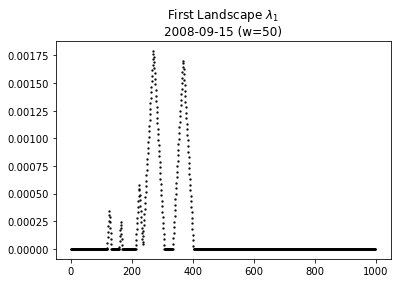

In [16]:
plt.scatter(np.arange(nb_nodes),landscapes[0],s=2,alpha=0.8,c='black')
tt = plt.title('First Landscape $\lambda_1$\n{} (w={})'.format(ending_date,window_size))

- The obtained figure corresponds exactly to the persistence landscape shown in Figure 8 of the paper, corresponding to the date 2008-09-15. To check the relevance of our code, we compute the persistence landscape for the 3 other dates:


<Figure size 432x288 with 0 Axes>

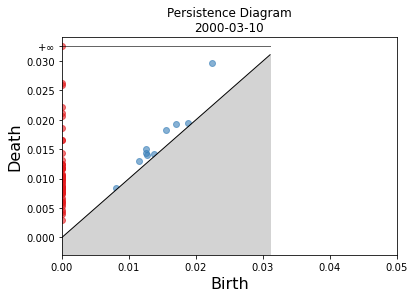

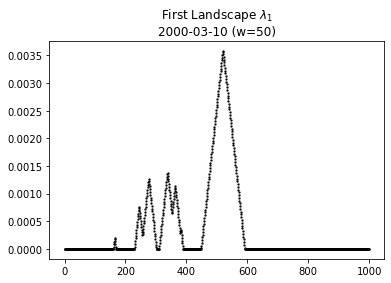

<Figure size 432x288 with 0 Axes>

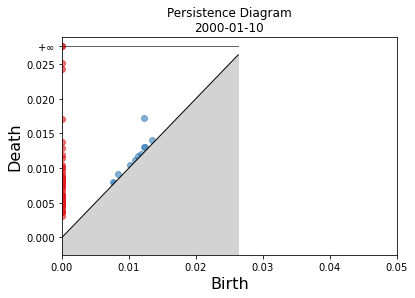

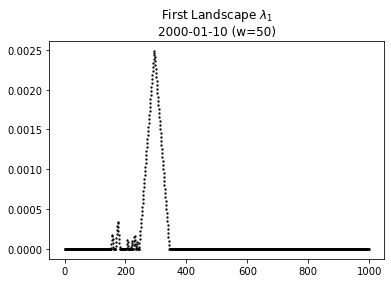

<Figure size 432x288 with 0 Axes>

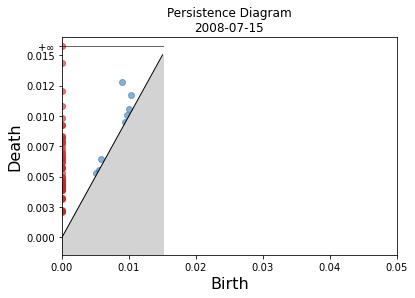

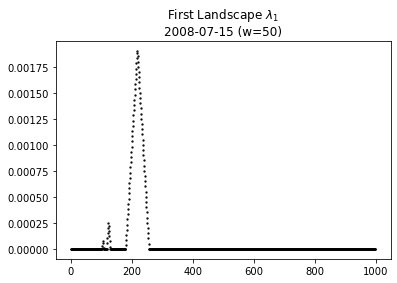

In [17]:
window_size = 50
date_list = ['2000-03-10','2000-01-10','2008-07-15']
for ending_date in date_list:
    
    #extract sliding window
    window = get_sliding_window_from_date(log_returns,ending_date,window_size,df=DowJones_pd)
    #compute persistence diagram of the wxd pointcloud
    skeleton = gd.RipsComplex(points = window.T, max_edge_length = 0.05)
    Rips_simplex_tree_sample = skeleton.create_simplex_tree(max_dimension = 2)
    dgm = Rips_simplex_tree_sample.persistence()
    #plot persistence diagram
    plt.figure()
    gd.plot_persistence_diagram(dgm)
    plt.xlim(0,0.05)
    tt = plt.title('Persistence Diagram\n{}'.format(ending_date))
    #compute persistence landscapes
    landscapes = get_persistence_landscapes(dgm,k,x_min,x_max,nb_nodes,nb_ld)
    #display first landscape
    plt.figure()
    plt.scatter(np.arange(nb_nodes),landscapes[0],s=2,alpha=0.8,c='black')
    tt = plt.title('First Landscape $\lambda_1$\n{} (w={})'.format(ending_date,window_size))

- Indeed, we obtain the same plots of figure 8 of the paper. 

## 3. Reproducing the results of section 4 of the paper

### 3.1 Method implementation and impact of the window size 

In this section, we will try to reproduce the results in figure 9 by proceeding as follows:

i) Fix a window size $w$ and a day $d$. From the set of $w$ datapoints in $\mathbb{R}^{4}$, compute persistence diagram using the Rip-Vitoris filtration.

ii) Compute the L1 and L2 norms of the first persistence landscape $\lambda_1$. Persistence landscapes are obtained using only 1-dimensional features of the persistence diagram.

iii) Repeate for all days in the period of interest. This will give us a two 1D time series, one for L1 norm and one for L2 norm.  

In [18]:
import tqdm.notebook as tq

def get_lansdscape_norms_ts(log_returns,w,nb_days,nb_ld,nb_nodes,x_min,x_max,k,method='paper'):
    
    
    #initialize landscape norms
    L1_norms =[]
    L2_norms = []
    for day in tq.tqdm(range(nb_days)):

        #get ordered time series sliding window for the correspoding day
        ts_sw = get_sliding_window_from_date_index(log_returns,day,w)

        #compute persistence diagram
        skeleton = gd.RipsComplex(points = ts_sw.T, max_edge_length = 0.05)
        Rips_simplex_tree_sample = skeleton.create_simplex_tree(max_dimension = 2)
        dgm = Rips_simplex_tree_sample.persistence()

        #compute first persistence landscape
        landscapes = get_persistence_landscapes(dgm,k,x_min,x_max,nb_nodes,nb_ld)
        if method=='paper':
            lambda_1 = landscapes[0]
            L1_norms.append(np.linalg.norm(lambda_1,ord=1))
            L2_norms.append(np.linalg.norm(lambda_1))
            
        if method.startswith('diff'):
            d = int(method[4])
            lambda_1 = landscapes[d-1]
            lambda_2 =  landscapes[d]
            l_ = lambda_1 - lambda_2
            L1_norms.append(np.linalg.norm(l_,ord=1))
            L2_norms.append(np.linalg.norm(l_))
            
        
            
        
    return np.array(L1_norms[::-1]), np.array(L2_norms[::-1])

First, we choose a value $w=50$ as in the paper.

In [19]:
#set window size
w = 50
nb_days = log_returns.shape[1] - w +1

#Set persistence landscape parameters
k = 1 #1-dimensional features
x_min = 0
x_max = 0.05 
nb_nodes = 1000
nb_ld = 2


print('Compute L1 and L2 norms of persistence landscapes for {} days...'.format(nb_days))

L1_norms , L2_norms = get_lansdscape_norms_ts(log_returns,w,nb_days,nb_ld,nb_nodes,x_min,x_max,k)

Compute L1 and L2 norms of persistence landscapes for 7251 days...


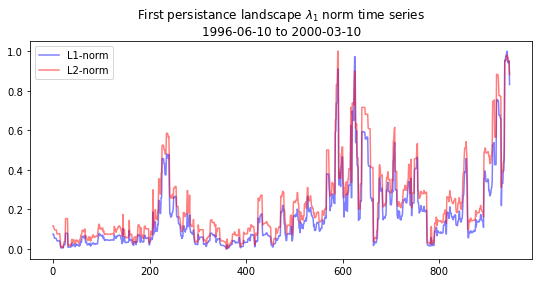

In [20]:
def plot_landscape_norms(L1_norms,L2_norms,begin_date,end_date,DowJones_pd,title,label1='L1-norm',label2='L2-norm'):
    """
    Plot L1 and L2 norms of the landscapes between two dates of choice
    @begin_date and @end_date : strings of the format 'yyyy-mm-dd'
    """
    norm_L1_norms = np.flip(L1_norms)#/L1_norms.max()
    norm_L2_norms = np.flip(L2_norms)#/L2_norms.max()

    
    begin_index = get_date_index(begin_date,DowJones_pd)
    #begin_index = end_index+960
    end_index = get_date_index(end_date,DowJones_pd)
    l1_plot = norm_L1_norms[end_index:begin_index]
    l1_plot = np.flip(l1_plot)
    l1_plot -= l1_plot.min()
    #normalize
    l1_plot/=l1_plot.max()
    l2_plot = norm_L2_norms[end_index:begin_index]
    l2_plot = np.flip(l2_plot)
    #normalize
    l2_plot -= l2_plot.min()
    l2_plot/=l2_plot.max()

    plt.figure(figsize = (9,4))
    plt.plot(l1_plot,'-b',alpha=0.5,label =label1)
    plt.plot(l2_plot,'-r',alpha=0.5,label =label2)
    tt =plt.title(title)
    lg = plt.legend()
    return 
    
   

begin_date = '1996-06-10'
end_date  = '2000-03-10'
title = 'First persistance landscape $\lambda_1$ norm time series\n{} to {}'.format(begin_date,end_date)
plot_landscape_norms(L1_norms,L2_norms,begin_date,end_date,DowJones_pd,title)


- The obtained figure is very similar to the time series displayed in Figure 9 of the paper https://arxiv.org/abs/1703.04385 . We obtain the same curves overall, we can see the same peaks in particular. 

- However, the main difference is that in our result, the L1-norm curve lies below the L2-norm curve, as opposed to what is observed in the figure 9. This might be an effect of normalization.

Now we would like to study the impact of the sliding window w on the L1 and L2 norms of persistence landscapes. To do so, we repeat the experiment for $w \in \{40,80,120\}$. 

In [50]:
def get_landscape_norms(window_sizes,log_returns,x_min,x_max,nb_nodes,nb_ld,k):
    """
    Returns two lists where each element of each list corresponds to a time series of the landscape norms
    for a given window size w
    
    @window_sizes: 
    """
    
    L1_norms = []
    L2_norms = []

    for w in window_sizes:
        nb_days = log_returns.shape[1] - w +1

        print('Compute L1 and L2 norms of persistence landscapes for {} days... using winodw size = {}'.format(nb_days,w))

        L1_norms_w , L2_norms_w = get_lansdscape_norms_ts(log_returns,w,nb_days,nb_ld,nb_nodes,x_min,x_max,k)
        L1_norms.append(L1_norms_w)
        L2_norms.append(L2_norms_w)

    return L1_norms,L2_norms

For persistence landscapes, we use the same parameters as in the previous sections ($x_{min}$,$x_{max}$,$nb_{nodes}$) and we compute only the first persistence landscape $\lambda_1$.

In [51]:
window_sizes = [40,80,120]

#Set persistence landscape parameters
k = 1 #1-dimensional features
x_min = 0
x_max = 0.05 
nb_nodes = 1000
nb_ld = 1

w_l1_norms , w_l2_norms = get_landscape_norms(window_sizes,log_returns,x_min,x_max,nb_nodes,nb_ld,k)

Compute L1 and L2 norms of persistence landscapes for 7261 days... using winodw size = 40



Compute L1 and L2 norms of persistence landscapes for 7221 days... using winodw size = 80



Compute L1 and L2 norms of persistence landscapes for 7181 days... using winodw size = 120


Remark : We observe that for larger window size values, the computation of persistence ladscape $\lambda_1$ takes significantly a much longer execuion time !

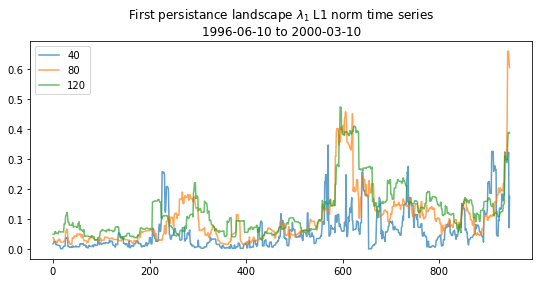

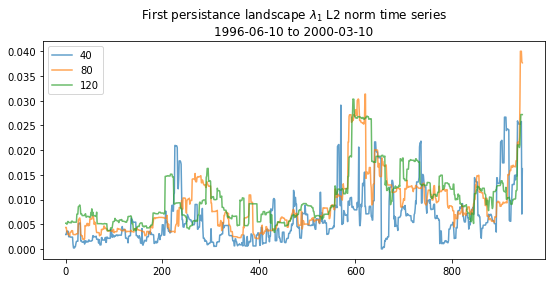

In [52]:
begin_date = '1996-06-10'
end_date  = '2000-03-10'

plt.figure(figsize = (9,4))
for i,curve in enumerate(w_l1_norms):
    plt.plot(np.flip(np.flip(curve)[end_index:begin_index]),alpha=0.7,label =str(window_sizes[i]))
    
tt =plt.title('First persistance landscape $\lambda_1$ L1 norm time series\n{} to {}'.format(begin_date,end_date))
lg = plt.legend()

plt.figure(figsize = (9,4))
for i,curve in enumerate(w_l2_norms):
    plt.plot(np.flip(np.flip(curve)[end_index:begin_index]),alpha=0.7,label =str(window_sizes[i]))
    
tt =plt.title('First persistance landscape $\lambda_1$ L2 norm time series\n{} to {}'.format(begin_date,end_date))
lg = plt.legend()

As in the previous experiment, we consider the period from 1996-06-10 to 2000-03-10 (date of the dotcom crash).

From the above figure, we observe that norms of persistence landscapes vary with the choice of the parameter $w$ and in particulat the choice $w=80$ presents the strongest increase in norm right before the crash.

However, we must emphasize that, depending on the observation period, a larger window size can result in either a significant increase or significant decrease in the first landscape norms. 


In fact, since the landscape norms mainly reflect the persistence of topological loops (1-dimensional features) in the wx4 data matrix this effect can be interpreted as follows : for a given date, increasing the size of the window $w$ can help detect new loops that did not appear for smaller values of $w$, therefore, in this case, an increase in the landscape norm is expected.

On the other hand, the observed decrease of the norms with higher $w$ values can be interpreted as follows:

Let us use the notation $\mathbb{L}_1$ to refer to the topological loops computed for $w=w_1$.
We note by $R_1$ the minimal radius that merges all connected components (when computing the Rips filtration). When we increase the size of the window to $w=w_2>w_1$  new datapoints are added to the space (in our case 4-dimensional). If the new points lie far enough from the initial $w_1$ points, computing the Rips filtration of the new larger point cloud could result in a larger $R_2$ value. Assuming the persistence of the loops $\mathbb{L}_1$ remains the same, their relative persistence (relative to the "duration" $R_2$) is smaller than in the case of $w=w_1$. Hence, in this case, the landscape of the loops $\mathbb{L}_1$ computed for $w=w_1$ become less significant. One way of looking at it is that if for $w=w_2$ the points in the persistence diagram have larger birth and death instants (than in the case of $w=w1$), and thus a larger interval $[x_{min},x_{max}]$  needs to be sampled to compute persistence landscapes. If we compute the persistence landscapes using the same numer of sampling points (in our case 1000) we would be subsampling significant points (i.e significant points within the the range of the loops $\mathbb{L}_1$ in the case of $w=w_2$, thus potentially explaining the observed decrease in the landscape norms (assuming the significant loops come from $\mathbb{L}_1$) 

### 3.2 Computing the varaince, the average spectral density and the ACF

In this part, our goal is to reproduce Figure 11 of the paper, in which the authors perform relevant statistics (variance, average spectral density, first lag of the auto-correlation function) over the times series obtained from the norms of  the first persistence landscape $\lambda_1$.
In particular, we will focus on two specific market crashes : Dotcom crash (2000-03-10) and Lehman crash (2008-09-15)

In [24]:
DowJones_pd['DateFormat'] = pd.to_datetime(DowJones_pd['Date'])

#### 3.2.1 DotCom crash

In [25]:
end_date  = '2000-03-10'
end_date_dateformat = pd.to_datetime(end_date)
number_of_days = 250

In [26]:
begin_date = DowJones_pd.sort_values(by='DateFormat').loc[DowJones_pd['DateFormat'] < end_date_dateformat]\
    .iloc[-number_of_days].Date
begin_date_dateformat = pd.to_datetime(begin_date)

In [27]:
begin_index = get_date_index(begin_date,DowJones_pd)
#begin_index = end_index+960
end_index = get_date_index(end_date,DowJones_pd)
w = 500

In [28]:
from scipy.signal import periodogram

norm_L1_norms = np.flip(L1_norms)#/L1_norms.max()
norm_L2_norms = np.flip(L2_norms)#/L2_norms.max()


mean_spectral_density_l1norm = np.zeros(begin_index-end_index)
mean_spectral_density_l2norm = np.zeros(begin_index-end_index)

for index in range(end_index, begin_index):
    _, Px_l1_norm = periodogram(x=norm_L1_norms[index:index+w], fs=2*0.8)
    _, Px_l2_norm = periodogram(x=norm_L2_norms[index:index+w], fs=2*0.8)
    mean_spectral_density_l1norm[index-end_index] = np.mean(Px_l1_norm)
    mean_spectral_density_l2norm[index-end_index] = np.mean(Px_l2_norm)

In [29]:
from statsmodels.tsa.stattools import acf

acf_l1_norm = np.zeros(begin_index-end_index)
acf_l2_norm = np.zeros(begin_index-end_index)

for index in range(end_index, begin_index):
    
    acf_l1_norm[index-end_index] = acf(norm_L1_norms[index: index+w], nlags=2)[-1]
    acf_l2_norm[index-end_index] = acf(norm_L2_norms[index: index+w], nlags=2)[-1]
    

In [30]:
variance_l1_norm = np.zeros(begin_index-end_index)
variance_l2_norm = np.zeros(begin_index-end_index)

for index in range(end_index, begin_index):
    variance_l1_norm[index-end_index] = np.var(norm_L1_norms[index: index+w])
    variance_l2_norm[index-end_index] = np.var(norm_L2_norms[index: index+w])

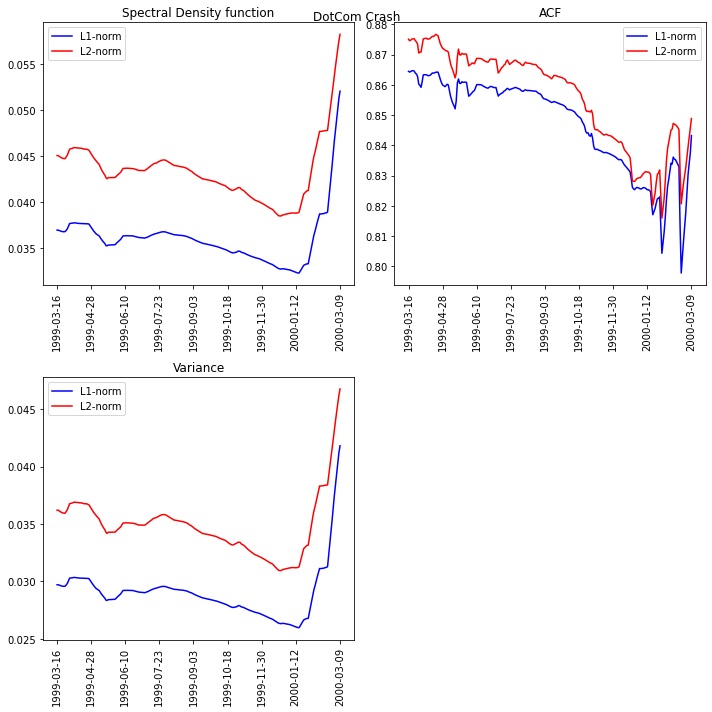

In [31]:
dates = np.flip(DowJones_pd.loc[(DowJones_pd['DateFormat'] >= begin_date_dateformat) \
                        & (DowJones_pd['DateFormat'] < end_date_dateformat), 'Date'].to_numpy())

fig = plt.figure(figsize=(10, 10))
fig.suptitle('DotCom Crash')
ax1 = plt.subplot(221)
ax1.plot(dates, np.flip(mean_spectral_density_l1norm), '-b', label='L1-norm')
ax1.plot(dates, np.flip(mean_spectral_density_l2norm), '-r', label='L2-norm')
ax1.set_xticks(ticks=dates[[i*30 for i in range(len(dates) // 30)] + [len(dates)-1]])
ax1.set_xticklabels(labels = dates[[i*30 for i in range(len(dates) // 30)] + [len(dates) -1]], 
                     rotation='vertical')
ax1.legend()
ax1.set_title('Spectral Density function')

ax2 = plt.subplot(222)
ax2.plot(dates, np.flip(acf_l1_norm), '-b', label='L1-norm')
ax2.plot(dates, np.flip(acf_l2_norm), '-r', label='L2-norm')
ax2.set_xticks(ticks=dates[[i*30 for i in range(len(dates) // 30)] + [len(dates)-1]])
ax2.set_xticklabels(labels = dates[[i*30 for i in range(len(dates) // 30)] + [len(dates) -1]], 
                     rotation='vertical')
ax2.legend()
ax2.set_title('ACF')

ax3 = plt.subplot(223)
ax3.plot(dates, np.flip(variance_l1_norm), '-b', label='L1-norm')
ax3.plot(dates, np.flip(variance_l2_norm), '-r', label='L2-norm')
ax3.set_xticks(ticks=dates[[i*30 for i in range(len(dates) // 30)] + [len(dates)-1]])
ax3.set_xticklabels(labels = dates[[i*30 for i in range(len(dates) // 30)] + [len(dates) -1]], 
                     rotation='vertical')
ax3.legend()
ax3.set_title('Variance')
plt.tight_layout()


- We reproduced the results form figure 11 in the paper except for the average spectral density of low frequencies where we have the same plot as the variance plot (the curves are almost identical, only the amplitude is different between the two plots that we obtained).

- As we can see the varaince of the L1 and L2 norm of the persistence landscape have a sudden mouvement upword just before the date of the DotCom Crash just as mentionned in the paper.

#### 3.2.2 Lehman Crash

In [33]:
end_date  = '2008-09-15'
end_date_dateformat = pd.to_datetime(end_date)
number_of_days = 250

In [34]:
begin_date = DowJones_pd.sort_values(by='DateFormat').loc[DowJones_pd['DateFormat'] < end_date_dateformat]\
    .iloc[-number_of_days].Date
begin_date_dateformat = pd.to_datetime(begin_date)

In [35]:
begin_index = get_date_index(begin_date,DowJones_pd)
#begin_index = end_index+960
end_index = get_date_index(end_date,DowJones_pd)
w = 500

In [36]:
from scipy.signal import periodogram

norm_L1_norms = np.flip(L1_norms)#/L1_norms.max()
norm_L2_norms = np.flip(L2_norms)#/L2_norms.max()


mean_spectral_density_l1norm = np.zeros(begin_index-end_index)
mean_spectral_density_l2norm = np.zeros(begin_index-end_index)

for index in range(end_index, begin_index):
    _, Px_l1_norm = periodogram(x=norm_L1_norms[index:index+w], fs=2*0.8)
    _, Px_l2_norm = periodogram(x=norm_L2_norms[index:index+w], fs=2*0.8)
    mean_spectral_density_l1norm[index-end_index] = np.mean(Px_l1_norm)
    mean_spectral_density_l2norm[index-end_index] = np.mean(Px_l2_norm)

In [37]:
from statsmodels.tsa.stattools import acf

acf_l1_norm = np.zeros(begin_index-end_index)
acf_l2_norm = np.zeros(begin_index-end_index)

for index in range(end_index, begin_index):
    
    acf_l1_norm[index-end_index] = acf(norm_L1_norms[index: index+w], nlags=2)[-1]
    acf_l2_norm[index-end_index] = acf(norm_L2_norms[index: index+w], nlags=2)[-1]
    

In [38]:
variance_l1_norm = np.zeros(begin_index-end_index)
variance_l2_norm = np.zeros(begin_index-end_index)

for index in range(end_index, begin_index):
    variance_l1_norm[index-end_index] = np.var(norm_L1_norms[index: index+w])
    variance_l2_norm[index-end_index] = np.var(norm_L2_norms[index: index+w])

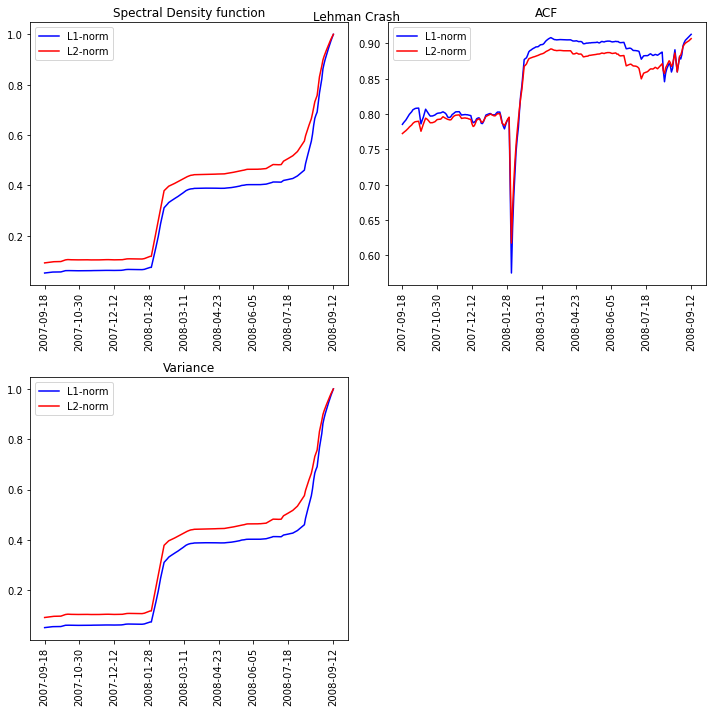

In [39]:
dates = np.flip(DowJones_pd.loc[(DowJones_pd['DateFormat'] >= begin_date_dateformat) \
                        & (DowJones_pd['DateFormat'] < end_date_dateformat), 'Date'].to_numpy())

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Lehman Crash')
ax1 = plt.subplot(221)
ax1.plot(dates, np.flip(mean_spectral_density_l1norm/np.max(mean_spectral_density_l1norm)), '-b', label='L1-norm')
ax1.plot(dates, np.flip(mean_spectral_density_l2norm/np.max(mean_spectral_density_l2norm)), '-r', label='L2-norm')
ax1.set_xticks(ticks=dates[[i*30 for i in range(len(dates) // 30)] + [len(dates)-1]])
ax1.set_xticklabels(labels = dates[[i*30 for i in range(len(dates) // 30)] + [len(dates) -1]], 
                     rotation='vertical')
ax1.legend()
ax1.set_title('Spectral Density function')

ax2 = plt.subplot(222)
ax2.plot(dates, np.flip(acf_l1_norm), '-b', label='L1-norm')
ax2.plot(dates, np.flip(acf_l2_norm), '-r', label='L2-norm')
ax2.set_xticks(ticks=dates[[i*30 for i in range(len(dates) // 30)] + [len(dates)-1]])
ax2.set_xticklabels(labels = dates[[i*30 for i in range(len(dates) // 30)] + [len(dates) -1]], 
                     rotation='vertical')
ax2.legend()
ax2.set_title('ACF')

ax3 = plt.subplot(223)
ax3.plot(dates, np.flip(variance_l1_norm)/np.max(variance_l1_norm), '-b', label='L1-norm')
ax3.plot(dates, np.flip(variance_l2_norm)/np.max(variance_l2_norm), '-r', label='L2-norm')
ax3.set_xticks(ticks=dates[[i*30 for i in range(len(dates) // 30)] + [len(dates)-1]])
ax3.set_xticklabels(labels = dates[[i*30 for i in range(len(dates) // 30)] + [len(dates) -1]], 
                     rotation='vertical')
ax3.legend()
ax3.set_title('Variance')
plt.tight_layout()



- We manage to reproduce the same figures as the ones presented in the figure 11 in the paper, and same as before, the norms of the first persistence landscape increases significantly prior to the crash. 

## 4. Experiments with the difference between consecutive landscapes


In this part we will try to use the norm of the difference of consecutive landscapes instead of the norm of the first landscape. 

We will begin by using the first 2 landscapes ($\lambda_1 - \lambda_2$) to repeat the experiment in section 4 of the paper. Similarly, we will use a window size $w=50$ and choose the date of 

In [ ]:
#set window size
w = 50
nb_days = log_returns.shape[1] - w +1

#Set persistence landscape parameters
k = 1 #1-dimensional features
x_min = 0
x_max = 0.05 
nb_nodes = 1000
nb_ld = 2
method= 'diff1'

print('Compute L1 and L2 norms of persistence landscapes for {} days...'.format(nb_days))

L1_norms_diff , L2_norms_diff = get_lansdscape_norms_ts(log_returns,w,nb_days,nb_ld,nb_nodes,x_min,x_max,k,method = method)

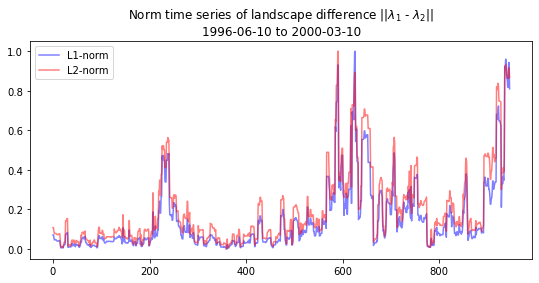

<Figure size 432x288 with 0 Axes>

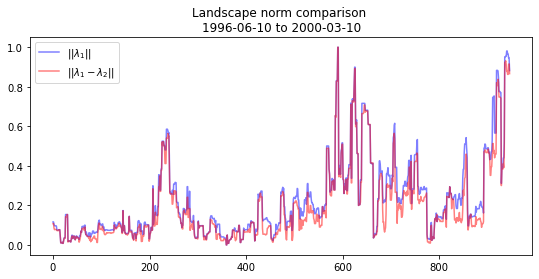

In [77]:

begin_date = '1996-06-10'
end_date  = '2000-03-10'
title = 'Norm time series of landscape difference ||$\lambda_1$ - $\lambda_2$|| \n{} to {}'.format(begin_date,end_date)

plot_landscape_norms(L1_norms_diff,L2_norms_diff,begin_date,end_date,DowJones_pd,title)
plt.figure()
title2 = 'Landscape norm comparison \n{} to {}'.format(begin_date,end_date)
label1 = '$||\lambda_1||$'
label2 = '$||\lambda_1 - \lambda_2||$'
plot_landscape_norms(L2_norms,L2_norms_diff,begin_date,end_date,DowJones_pd,title2,label1,label2)


- The obtained result is very similar to the case where we only se the first landscape $\lambda1$. This is mainly due to the fact that $\lambda_2 << \lambda_1$ which can be directly observed in the below figure

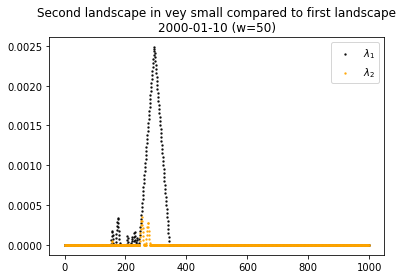

In [82]:
k = 1 #1-dimensional features
x_min = 0
x_max = 0.05#aucune idée pourquoi cette valeur mais ça me donne une jolie figure là dessous
nb_nodes = 1000
nb_ld = 2

#choose a valid date between '1996-06-10' and '2000-03-10'
ending_date = '2000-01-10'
window_size = 50
window = get_sliding_window_from_date(log_returns,ending_date,window_size,df=DowJones_pd)

skeleton = gd.RipsComplex(points = window.T, max_edge_length = 0.05)
Rips_simplex_tree_sample = skeleton.create_simplex_tree(max_dimension = 2)
dgm = Rips_simplex_tree_sample.persistence()

landscapes1_2 = get_persistence_landscapes(dgm,k,x_min,x_max,nb_nodes,nb_ld)
plt.scatter(np.arange(nb_nodes),landscapes1_2[0],s=2,alpha=0.8,c='black',label='$\lambda_1$')
plt.scatter(np.arange(nb_nodes),landscapes1_2[1],s=2,alpha=0.8,c='orange',label='$\lambda_2$')
tt = plt.title('Second landscape in vey small compared to first landscape\n{} (w={})'.format(ending_date,window_size))
lg = plt.legend()

In [64]:
#set window size
w = 50
nb_days = log_returns.shape[1] - w +1

#Set persistence landscape parameters
k = 1 #1-dimensional features
x_min = 0
x_max = 0.05 #aucune idée pourquoi cette valeur mais ça me donne une jolie figure là dessous
nb_nodes = 1000
nb_ld = 3
method= 'diff2'

print('Compute L1 and L2 norms of persistence landscapes for {} days...'.format(nb_days))

L1_norms_diff2 , L2_norms_diff2 = get_lansdscape_norms_ts(log_returns,w,nb_days,nb_ld,nb_nodes,x_min,x_max,k,method = method)

Compute L1 and L2 norms of persistence landscapes for 7251 days...


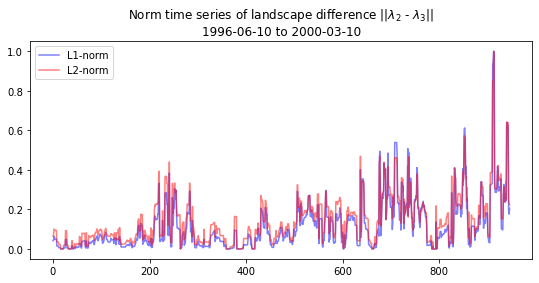

In [69]:

begin_date = '1996-06-10'
end_date  = '2000-03-10'
title = 'Norm time series of landscape difference ||$\lambda_2$ - $\lambda_3$|| \n{} to {}'.format(begin_date,end_date)

plot_landscape_norms(L1_norms_diff2,L2_norms_diff2,begin_date,end_date,DowJones_pd,title)

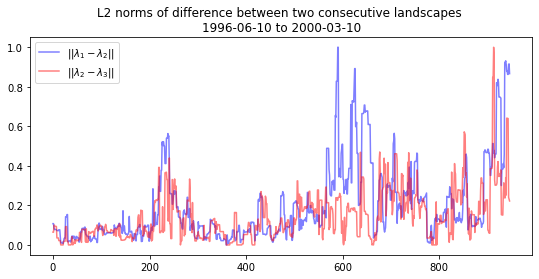

In [75]:
begin_date = '1996-06-10'
end_date  = '2000-03-10'
title = 'L2 norms of difference between two consecutive landscapes \n{} to {}'.format(begin_date,end_date)
label1 = '$||\lambda_1 - \lambda_2||$'
label2 = '$||\lambda_2 - \lambda_3||$'
plot_landscape_norms(L2_norms_diff,L2_norms_diff2,begin_date,end_date,DowJones_pd,title,label1,label2)

- Eventhough the second and third landscapes have smaller values compared to the first landscape, the difference $||\lambda_2 - \lambda_3||$ encodes most of the information present when using $||\lambda_1 - \lambda_2||$ (which is almost identical to only using $\lambda_1$). In fact, we observe from the above figure that the normalized curves are correlated and most importantly , they present high peaks as we approach the date 2000-03-10 corresponding to dotcom crash. However, the peak of red curve prior to the crash exibits a certain delay and is ubrupt which could be misleading while analyzing the time series, whereas we clearly observe that the peak of the blue curve builds up prior to the crash until reaching a maximal value closer to the corresponding date. For this using the paper's method might be more relevant to avoid "false alarms". 